# Sentiment Analysis on Movie Reviews

* The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis, originally collected by Pang and Lee. 
* This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. 
* Label phrases on a scale of five values: 
    * negative
    * somewhat negative 
    * neutral
    * somewhat positive 
    * positive. 
    
* Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.

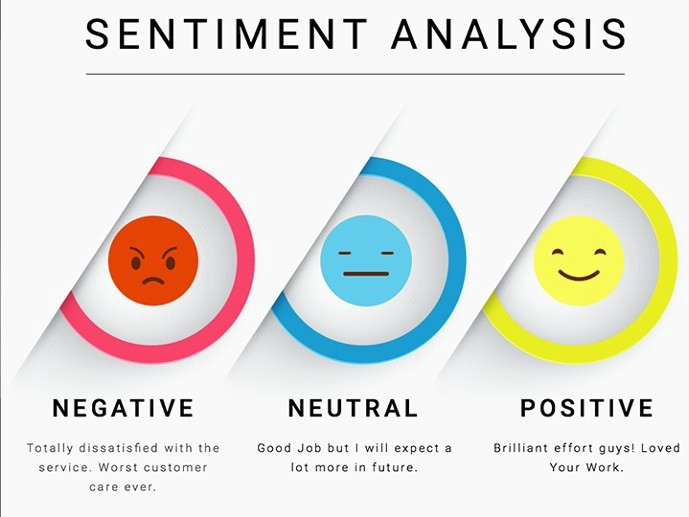

### Some basic information about dataset
* The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order.

    * train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
    * test.tsv contains just phrases. You must assign a sentiment label to each phrase.

### Import libraries

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
np.random.seed(101)

In [2]:
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop = stopwords.words('english')
from nltk import pos_tag
from nltk.corpus import wordnet

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

### Explore data

In [2]:
data = pd.read_table('train.tsv')

print(data.shape)
display(data.head())

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


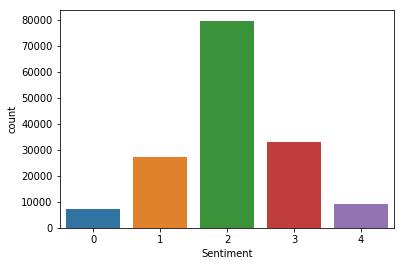

In [3]:
sns.countplot('Sentiment', data = data)
plt.show()

### Preprocess data

In [6]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    return tag_dict.get(tag, wordnet.NOUN)

## Define function for clean a word in a text
def preprocess(text):
    clean_data = []
    for new_text in text.split():
        lemmatizer = WordNetLemmatizer()
        new_text = re.sub(r'[^\w\s]', '', new_text) # remove punc.
        new_text = re.sub(r'\d+','',new_text)# remove numbers
        new_text = new_text.lower() # lower case, .upper() for upper
        if new_text != '':
            clean_data.append(lemmatizer.lemmatize(new_text))
    return str(clean_data)

In [17]:
X = data['Phrase']
y = data['Sentiment']

#split data for training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 101, stratify = y)

print(X_train.shape)
print(X_test.shape)

(124848,)
(31212,)


#### Create CountVectorizer and TfidfVectorizer for data

In [22]:
cvt = CountVectorizer(binary=True,analyzer='word', 
                             ngram_range=(1, 3), stop_words = 'english', 
                             preprocessor=preprocess)

tfidfvt = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), 
                          stop_words = 'english', preprocessor=preprocess)

In [23]:
count_train = cvt.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = cvt.transform(X_test)

# Print the first 10 features of the count_vectorizer
print(cvt.get_feature_names()[:10])

C:\Users\philo\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


['aaa', 'aaa action', 'aaa action xxx', 'aaliyah', 'aaliyah minute', 'aaliyah minute screen', 'aaliyah starring', 'aaliyah starring role', 'aan', 'aan opportunity']


In [29]:
len(cvt.get_feature_names())

126024

In [19]:
# Transform the training data: tfidf_train 
tfidf_train = tfidfvt.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidfvt.transform(X_test)

# Print the first 10 features
print(tfidfvt.get_feature_names()[:10])

['aaa', 'aaa action', 'aaa action xxx', 'aaliyah', 'aaliyah minute', 'aaliyah minute screen', 'aaliyah starring', 'aaliyah starring role', 'aan', 'aan opportunity']


In [38]:
len(tfidfvt.get_feature_names())

126024

In [39]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)
# Calculate the confusion matrix: cm
cm = confusion_matrix(y_test, pred)
print(cm)

0.6181276432141484
[[  606   608   184    13     3]
 [  626  2559  2027   215    28]
 [  231  1685 11933  1857   210]
 [   30   252  2118  3365   821]
 [    1    20   158   832   830]]


In [40]:
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = confusion_matrix(y_test, pred)
print(cm)

0.6152120979110598
[[   97   660   645    12     0]
 [   40  1602  3715    98     0]
 [    2   580 14580   748     6]
 [    0    54  3740  2732    60]
 [    0     4   530  1116   191]]


In [20]:
# Instantiate a Logistic regression
lm = LogisticRegression()

# Fit the classifier to the training data
lm.fit(count_train, y_train)

# Create the predicted tags: pred
pred = lm.predict(count_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)
# Calculate the confusion matrix: cm
cm = confusion_matrix(y_test, pred)
print(cm)

C:\Users\philo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\philo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6536588491605793
[[  483   630   292     9     0]
 [  352  2243  2718   133     9]
 [   62   983 13833   983    55]
 [    9    95  2859  3126   497]
 [    1     9   214   900   717]]


In [21]:
# Instantiate a Logistic regression (best parameter penalty ='l2', C=7)
lm = LogisticRegression()

# Fit the classifier to the training data
lm.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = lm.predict(tfidf_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)
# Calculate the confusion matrix: cm
cm = confusion_matrix(y_test, pred)
print(cm)

0.6210111495578624
[[  233   596   568    17     0]
 [  103  1581  3657   111     3]
 [   13   612 14517   747    27]
 [    5    61  3645  2712   163]
 [    0     8   497   996   340]]


### Submit 3rd

In [64]:
## test for logistic regression model in tfidf
test = pd.read_table('test.tsv')

test_set = test['Phrase']
tfidf_test = tfidfvt.transform(test_set) 

In [66]:
predictions = lm.predict(tfidf_test)
final_answer = pd.DataFrame({'PhraseId':test['PhraseId'],'Sentiment':predictions})
final_answer.to_csv('submit_3.csv', index = False)

#### Apply SVM

In [ ]:
#truncated dataset for support vector machine
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = TruncatedSVD(n_components=120)
svd.fit(tfidf_train)
train_svd = svd.transform(tfidf_train)
test_svd = svd.transform(tfidf_test)

In [12]:
# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = StandardScaler()
scl.fit(train_svd)
train_svd_scl = scl.transform(train_svd)
test_svd_scl = scl.transform(test_svd)

In [ ]:
# Fitting a simple SVM
svc = SVC(C=1.0)
svc.fit(train_svd_scl, y_train)
pred = svc.predict(test_svd_scl)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)
# Calculate the confusion matrix: cm
cm = confusion_matrix(y_test, pred)
print(cm)

### Tuning Models

In [22]:
#create a small dataset for gridsearch
index = round(tfidf_train.shape[0] * 0.6)
cross_set = count_train[:index]
cross_y = y_train[:index]

tic = time.process_time()
lm = LogisticRegression()

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(lm, hyperparameters, cv=5, verbose=0, n_jobs=-1)

clf.fit(cross_set, cross_y)

toc = time.process_time()
print(f'Processing Time: {toc - tic}')

C:\Users\philo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\philo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Processing Time: 11.34375


In [23]:
clf.best_score_

0.6360517427812412

In [24]:
clf.best_params_

{'C': 2.7825594022071245, 'penalty': 'l1'}

In [24]:
### test new parameter with model C = 2.7 and penalty l1 

# Instantiate a Logistic regression
lm = LogisticRegression(C=2.7, penalty ='l1')

# Fit the classifier to the training data
lm.fit(count_train, y_train)

# Create the predicted tags: pred
pred = lm.predict(count_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)
# Calculate the confusion matrix: cm
cm = confusion_matrix(y_test, pred)
print(cm)

C:\Users\philo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\philo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6590734332948865
[[  559   658   184    12     1]
 [  451  2524  2321   144    15]
 [   83  1194 13365  1206    68]
 [   12   136  2504  3322   612]
 [    2     7   142   889   801]]


### Submit 4th

* LogisticRegression (C=2.7, penalty='l1')
* CountVectorize

In [14]:
## test for logistic regression model in countvectorize
test = pd.read_table('test.tsv')

test_set = test['Phrase']
count_test = cvt.transform(test_set)

In [15]:
predictions = lm.predict(count_test)
final_answer = pd.DataFrame({'PhraseId':test['PhraseId'],'Sentiment':predictions})
final_answer.to_csv('submit_4.csv', index = False)

### Submit 5th

* LogisticRegression (C=2.7, penalty='l1')
* CountVectorize with binary

In [25]:
## test for logistic regression model in countvectorize
test = pd.read_table('test.tsv')

test_set = test['Phrase']
count_test = cvt.transform(test_set)

predictions = lm.predict(count_test)
final_answer = pd.DataFrame({'PhraseId':test['PhraseId'],'Sentiment':predictions})
final_answer.to_csv('submit_5.csv', index = False)